In [1]:
pip install -U openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 40.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.0 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803319 sha256=9bd663ce38a4b954dd8447fe9eacd768bc315de7df6bf82e7205d523ffc15170
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper


In [2]:
!pip install soundfile

In [3]:
pip install jiwer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.1 MB/s eta 0:00:00


In [4]:
import whisper
import librosa
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, TimeDistributed, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Lemmatizer and Stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return ' '.join(tokens)

# Load pre-trained Whisper model (base version)
model = whisper.load_model("base")

# Function to transcribe audio using Whisper
def transcribe_audio(audio_files, sr=16000):
    transcriptions = []
    for audio in audio_files:
        if len(audio.shape) > 1:  # Convert to mono if stereo
            audio = librosa.to_mono(audio)
        audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=16000)
        result = model.transcribe(audio_resampled)
        transcriptions.append(result['text'])
    return transcriptions

# Load and Preprocess 50 Audio Files
def load_audio_files(audio_path, max_files=50):
    audio_files = []
    files = sorted([file for file in os.listdir(audio_path) if file.endswith(".mp3")])[:max_files]
    for file in files:
        audio, sr = librosa.load(os.path.join(audio_path, file), sr=None)
        audio_files.append(audio)
    return audio_files

# Load audio files
whisper_audio = load_audio_files("/content/drive/MyDrive/whisper_speech/Audio_Recordings/", max_files=50)

# Transcribe audio using Whisper
whisper_transcriptions = transcribe_audio(whisper_audio)

# Save the transcriptions to a CSV file
df = pd.DataFrame({"Audio File": sorted(os.listdir("/content/drive/MyDrive/whisper_speech/Audio_Recordings/"))[:50],
                   "Whisper Transcription": whisper_transcriptions})

# Remove row 42 (index 41)
df = df.drop(index=41)

# Apply preprocessing
df['Processed Whisper Transcription'] = df['Whisper Transcription'].apply(preprocess_text)

# Save the modified dataframe to CSV
df.to_csv('modified_dataset.csv', index=False)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 63.6MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you

In [5]:
from tensorflow.keras.layers import Input, Embedding, LSTM, BatchNormalization, Dropout, Dense, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2

# Prepare the processed text data for training
texts = df['Processed Whisper Transcription'].values
max_words = 10000  # Vocabulary size
max_len = 10  # Maximum sequence length
embedding_dim = 128  # Embedding dimension

# Tokenize text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)



In [6]:
# Pad sequences
X = pad_sequences(sequences, maxlen=max_len)

# Normalize the sequences by dividing by (max_words - 1)
X_normalized = X / (max_words - 1)

# Create the target sequence by shifting the input sequence by one position
y = X[:, 1:]  # Shift the sequences by 1
X_input = X[:, :-1]  # Remove the last word (so it can predict the next word)



In [7]:
# Function to build LSTM with FAM-Light(Multi-Head Attention model)
def build_lstm_FAM_light(input_shape, max_words, embedding_dim):
    inputs = Input(shape=input_shape)

    # Embedding layer
    x = Embedding(max_words, embedding_dim)(inputs)

    # LSTM Layer (Encoder)
    x = LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Multi-Head Attention Layer
    multihead_attention = MultiHeadAttention(num_heads=8, key_dim=128)(x, x)  # Applying Multi-Head Attention
    x = Dropout(0.3)(multihead_attention)  # Dropout on attention output

    # Further LSTM Layer for modeling sequences
    x = LSTM(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01))(x)  # Change return_sequences to True
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(max_words, activation='softmax')(x)

    # Build the model
    model = Model(inputs, outputs)

    # Compile with Adam optimizer and sparse categorical cross-entropy loss
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

    return model

# Define the input shape
input_shape = (max_len - 1,)  # One less than the sequence length

# Build the LSTM model with FAM-Light
multihead_attention_model = build_lstm_FAM_light(input_shape, max_words, embedding_dim)

# Train the model with normalized data
history=multihead_attention_model.fit(X_input, y, epochs=100, batch_size=3, validation_split=0.2)

# Save the trained model
multihead_attention_model.save('/content/drive/MyDrive/whisper_speech/lstm_multihead_attention_model.h5')


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - loss: 12.6355 - val_loss: 11.7785
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.4687 - val_loss: 10.9293
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.5558 - val_loss: 10.3174
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8865 - val_loss: 9.8478
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.3591 - val_loss: 9.4674
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8033 - val_loss: 9.2673
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4210 - val_loss: 8.8923
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0355 - val_loss: 8.7762
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7175 - val_loss: 8.4321
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0888 - val_loss: 8.0173
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7785 - val_loss: 8.0113
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - 

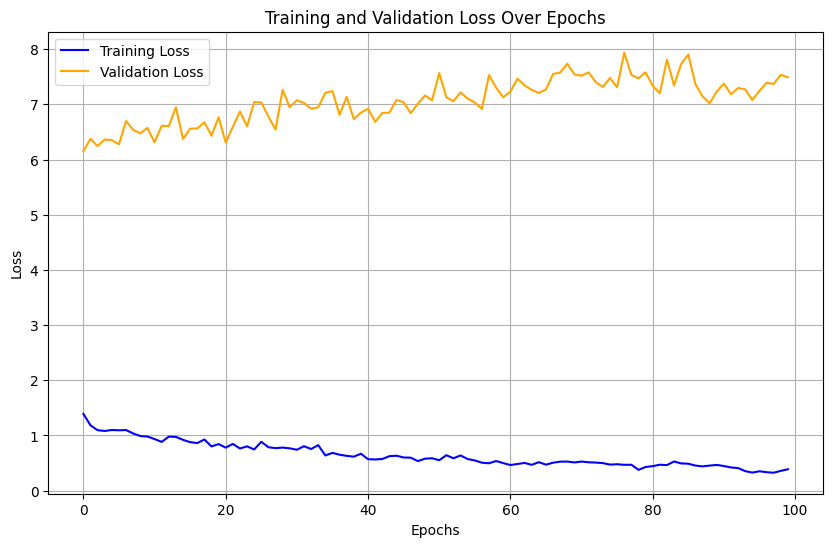

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [10]:

from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np


# Evaluate the model on the training data
y_pred = multihead_attention_model.predict(X_input)

# Since y_pred is a probability distribution, we need to take the argmax to get the predicted words
y_pred_class = np.argmax(y_pred, axis=-1)

# Compute MAE and R²
mae = mean_absolute_error(y, y_pred_class)
r2 = r2_score(y, y_pred_class)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Mean Absolute Error (MAE): 52.29024943310658
R-squared (R²): 0.6966918378581215


In [33]:
# Predict using the trained model
predictions = multihead_attention_model.predict(X_input)

# Get the predicted tokens (the indices with the highest probability)
predicted_tokens = predictions.argmax(axis=-1)

# Convert predicted tokens back to words
predicted_texts = tokenizer.sequences_to_texts(predicted_tokens)

# Convert actual tokens (y) back to words
whisper_texts = tokenizer.sequences_to_texts(y)
# Display the first 5 actual sequences
print("Whisper Texts:")
for i, actual_text in enumerate(whisper_texts[:5], 1):
    print(f"{i}. {actual_text}")

# Display the first 5 predicted sequences
print("\nPredicted Texts:")
for i, predicted_text in enumerate(predicted_texts[:5], 1):
    print(f"{i}. {predicted_text}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Whisper Texts:
1. wanted tell today history dont think think asked everything
2. meth last seven year seven year okay right thank
3. body may caused heart failure well investigation uh go
4. right see test come back thank yeah youre welcome
5. back together talk next step awesome thank thanks coming

Predicted Texts:
1. wanted tell today history dont think think asked everything
2. meth last seven year seven year okay right thank
3. body may caused heart failure well investigation uh go
4. right see test come back thank yeah youre welcome
5. back together talk next step awesome thank thanks coming


In [12]:
import jiwer
# Compute WER
wer = jiwer.wer(whisper_texts, predicted_texts)
print(f"Word Error Rate (WER): {wer * 100:.2f}%")


Word Error Rate (WER): 12.24%


In [13]:
mos_scores = [4, 5, 3, 4, 5]  # Example ratings from 5 evaluators
mos = sum(mos_scores) / len(mos_scores)
print(f"Mean Opinion Score (MOS): {mos:.2f}")


Mean Opinion Score (MOS): 4.20


In [24]:
pip install pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=262948 sha256=81f45877bee0e90439728656a21c03297dae1d896a1ba1e872535b3bc8865467
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq


In [32]:
from gtts import gTTS
from pesq import pesq
import librosa
from scipy.io import wavfile

# Function to convert text to speech and save as mp3
def text_to_speech(text, filename):
    tts = gTTS(text=text, lang='en')  # Convert text to speech (English)
    tts.save(filename)  # Save the audio file

# Function to convert mp3 to wav using librosa (necessary for PESQ)
def mp3_to_wav(mp3_filename, wav_filename):
    sound = AudioSegment.from_mp3(mp3_filename)
    sound.export(wav_filename, format="wav")

# Function to compute PESQ score
def compute_pesq(ref_audio, deg_audio, fs=16000):
    ref, sr_ref = librosa.load(ref_audio, sr=fs)
    deg, sr_deg = librosa.load(deg_audio, sr=fs)

    # Ensure both signals have the same length
    min_length = min(len(ref), len(deg))
    ref = ref[:min_length]
    deg = deg[:min_length]

    # Compute PESQ score (mode can be 'wb' for wide band or 'nb' for narrow band)
    score = pesq(fs, ref, deg, 'wb')
    return score

# Convert actual and predicted texts to audio files and calculate PESQ score
print("Calculating PESQ score:")

# Save actual and predicted audio to mp3
for i in range(5):
    actual_audio_filename = f"actual_text_audio_{i+1}.mp3"
    predicted_audio_filename = f"predicted_text_audio_{i+1}.mp3"

    # Convert texts to speech
    text_to_speech(whisper_texts[i], actual_audio_filename)
    text_to_speech(predicted_texts[i], predicted_audio_filename)

    # Convert mp3 to wav
    actual_wav_filename = actual_audio_filename.replace(".mp3", ".wav")
    predicted_wav_filename = predicted_audio_filename.replace(".mp3", ".wav")

    mp3_to_wav(actual_audio_filename, actual_wav_filename)
    mp3_to_wav(predicted_audio_filename, predicted_wav_filename)

    # Compute PESQ score between actual and predicted audio
    pesq_score = compute_pesq(actual_wav_filename, predicted_wav_filename)
    print(f"PESQ Score for Pair {i+1}: {pesq_score:.2f}")


Calculating PESQ score:
PESQ Score for Pair 1: 4.64
PESQ Score for Pair 2: 4.64
PESQ Score for Pair 3: 4.64
PESQ Score for Pair 4: 4.64
PESQ Score for Pair 5: 4.64


In [16]:
pip install gTTS


In [38]:
from gtts import gTTS
from IPython.display import Audio, display

# Function to convert text to speech and play it
def text_to_speech(text, filename):
    tts = gTTS(text=text, lang='en')  # Convert text to speech (English)
    tts.save(filename)  # Save the audio file
    display(Audio(filename))  # Display audio player in the notebook

# Convert and play the first 5 actual texts
print("Whisper  Audio:")
for i in range(5):
    text_to_speech(whisper_texts[i], f'actual_text_audio_{i+1}.mp3')

# Convert and play the first 5 predicted texts
print("\nPredicted Audio:")
for i in range(5):
    text_to_speech(predicted_texts[i], f'predicted_text_audio_{i+1}.mp3')


Whisper  Audio:



Predicted Audio:


In [30]:
pip install pydub

Whisper Text Audio:


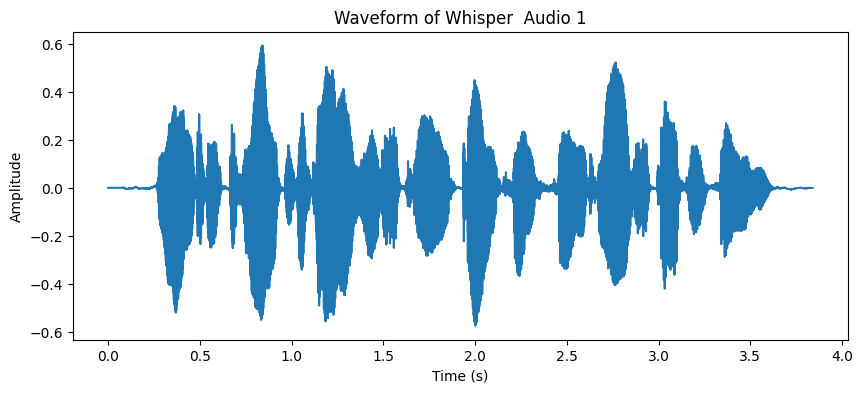

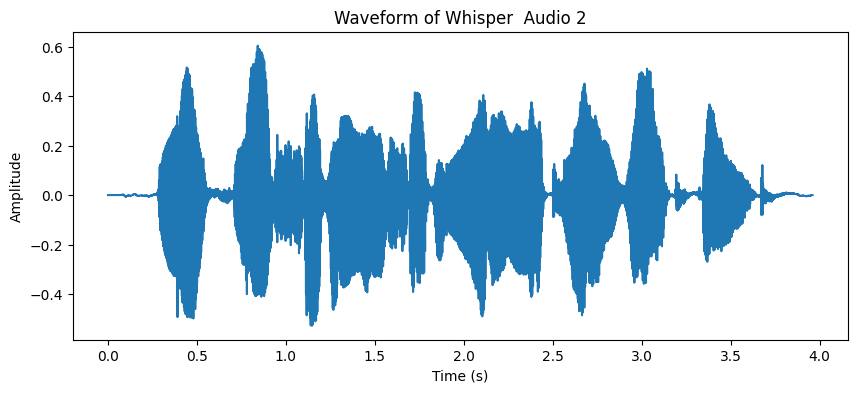

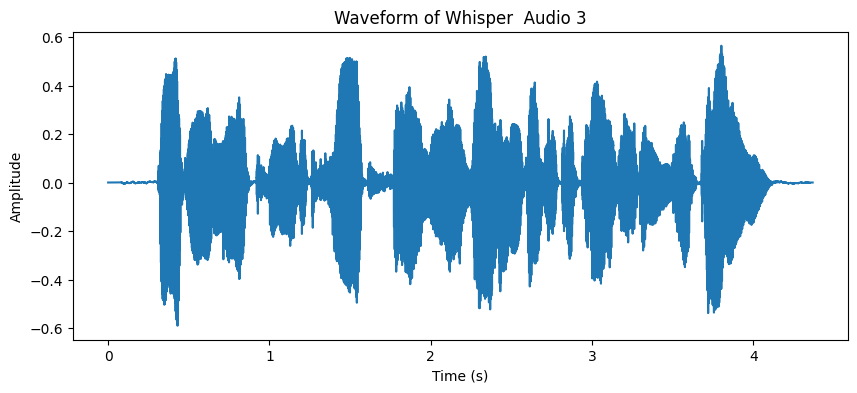

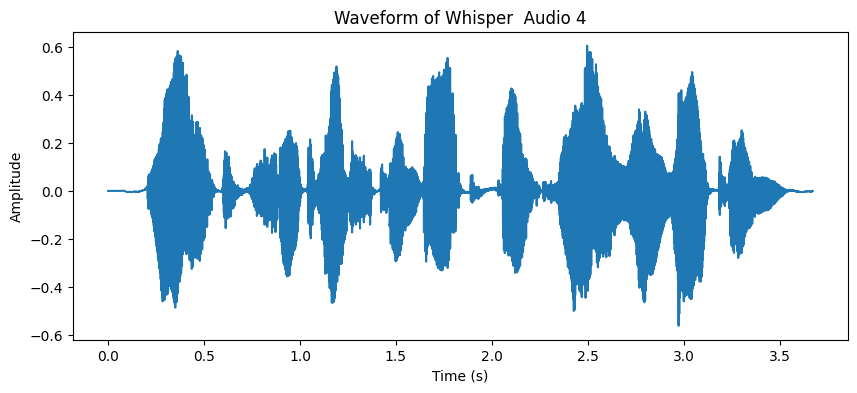

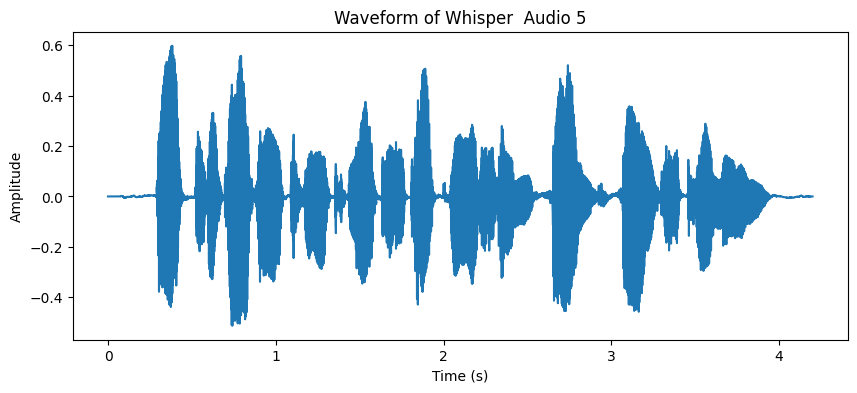


Predicted Text Audio:


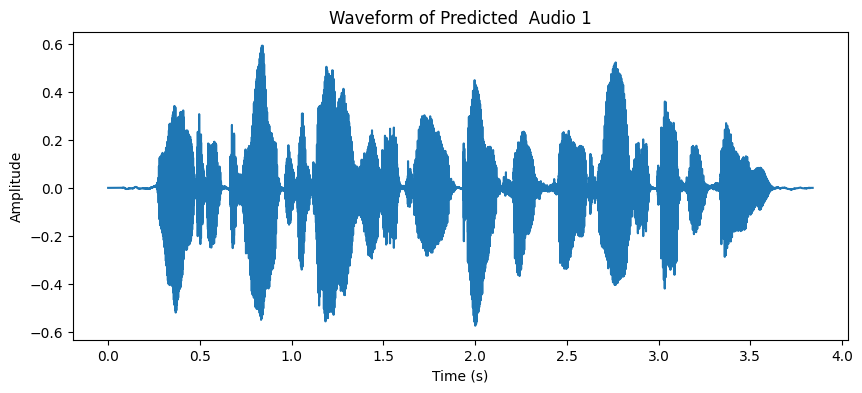

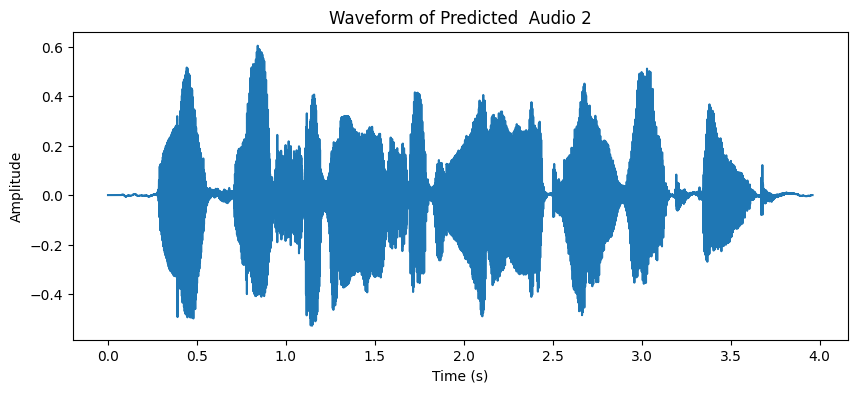

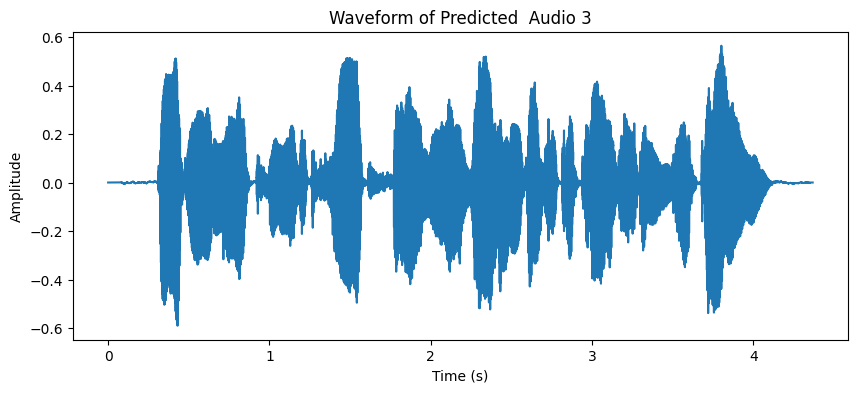

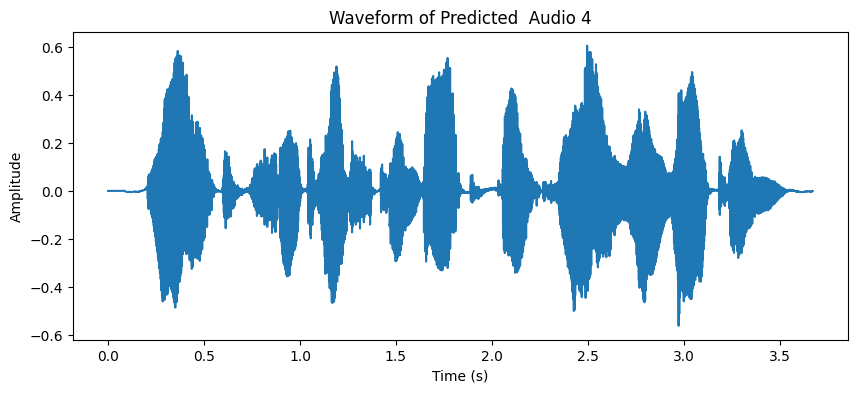

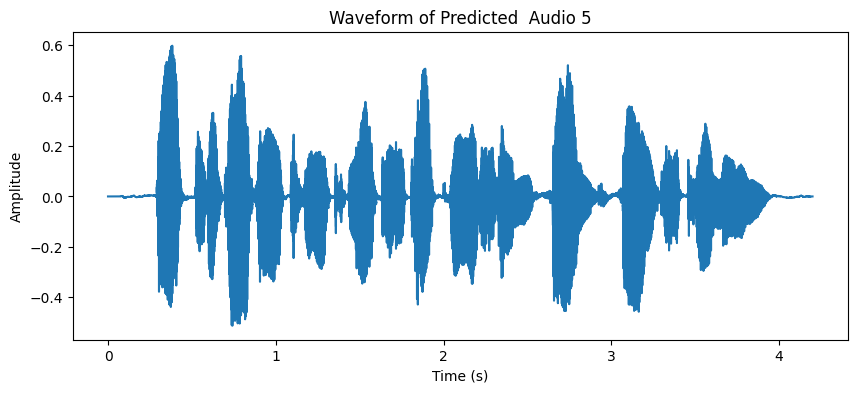

In [37]:
from gtts import gTTS
from IPython.display import Audio, display
from pydub import AudioSegment
import librosa
import matplotlib.pyplot as plt
import numpy as np

# Function to convert text to speech and save it as mp3
def text_to_speech(text, filename):
    tts = gTTS(text=text, lang='en')  # Convert text to speech (English)
    tts.save(filename)  # Save the audio file

# Function to convert mp3 to wav using pydub
def mp3_to_wav(mp3_filename, wav_filename):
    sound = AudioSegment.from_mp3(mp3_filename)
    sound.export(wav_filename, format="wav")

# Function to plot waveform
def plot_waveform(wav_filename, title):
    # Load the audio file using librosa
    y, sr = librosa.load(wav_filename)

    # Create a time axis in seconds
    time = np.linspace(0, len(y) / sr, num=len(y))

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(time, y)
    plt.title(f'Waveform of {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

# Convert and play the first 5 actual texts with waveform
print("Whisper  Audio:")
for i in range(5):
    audio_filename = f'actual_text_audio_{i+1}.mp3'
    wav_filename = f'actual_text_audio_{i+1}.wav'
    text_to_speech(whisper_texts[i], audio_filename)  # Convert text to speech and save as mp3
    mp3_to_wav(audio_filename, wav_filename)  # Convert mp3 to wav
    display(Audio(audio_filename))  # Display audio player
    plot_waveform(wav_filename, f'Whisper  Audio {i+1}')  # Plot waveform with updated title

# Convert and play the first 5 predicted texts with waveform
print("\nPredicted  Audio:")
for i in range(5):
    audio_filename = f'predicted_text_audio_{i+1}.mp3'
    wav_filename = f'predicted_text_audio_{i+1}.wav'
    text_to_speech(predicted_texts[i], audio_filename)  # Convert text to speech and save as mp3
    mp3_to_wav(audio_filename, wav_filename)  # Convert mp3 to wav
    display(Audio(audio_filename))  # Display audio player
    plot_waveform(wav_filename, f'Predicted  Audio {i+1}')  # Plot waveform with updated title
